<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reset -f

In [2]:
! pip install kornia
!rm -rf nn_hallucinations
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

     |████████████████████████████████| 143kB 21.3MB/s 
Cloning into 'nn_hallucinations'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 17 (delta 7), reused 12 (delta 4), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [3]:
import collections
import copy
import importlib

import PIL
import kornia
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import init
from torch import optim
from torchvision import transforms
from torchvision import models

def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(get_device())

cuda


In [4]:
colab_utils.upload_files()
!ls /tmp

Saving dancing.jpg to dancing.jpg
Saving picaso.jpg to picaso.jpg
['picaso.jpg', 'dancing.jpg']
dancing.jpg  picaso.jpg


# Neural Style Transfer

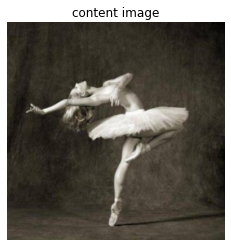

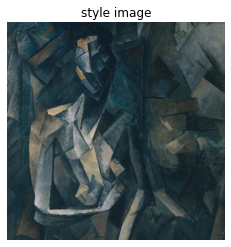

In [6]:
imsize = 512 if torch.cuda.is_available() else 128  # Use a small size on CPU.

content_img = colab_utils.load_image("/tmp/dancing.jpg", size=imsize)
content_img = content_img.unsqueeze(0).to(get_device())
style_img = colab_utils.load_image("/tmp/picaso.jpg", size=imsize)
style_img = style_img.unsqueeze(0).to(get_device())

colab_utils.imshow(content_img, title="content image")
colab_utils.imshow(style_img, title="style image")

In [0]:
class ImagenetNormalize(nn.Module):
  """Module which normalizes inputs using the ImageNet mean and stddev."""

  def __init__(self):
    super().__init__()
    self._transform = transforms.Normalize(
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

  def forward(self, input):
    # Remove the batch dimension before transforming then add it back.
    # Warning: This only produces sane results when batch_size=1.
    return self._transform(input.squeeze(0)).unsqueeze(0)


class ContentLoss(nn.Module):
  """The content loss module.
  
  Computes the L1 loss between the target and the input.
  """

  def __init__(self, target):
    """Initializes a new ContentLoss instance.
    
    Args:
      target: Take the L1 loss with respect to this target.
    """
    super().__init__()
    # We detach the target from the computation graph since we want to use the
    # actual value.
    self._target = target.detach()
    self._loss = None

  def forward(self, input):
    self.loss = F.l1_loss(input, self._target)
    return input


class StyleLoss(nn.Module):
  """The style loss module.
  
  Computes the L1 loss between the gram matricies of the target feature and the
  input.
  """

  def __init__(self, target_feature):
    """Initializes a new StyleLoss instance.
    
    Args:
      target_feature: Take the L1 loss with respect to this target feature.
    """
    super().__init__()
    # We detach the target_feature and target from the computation graph since
    # we want to use the actual values.
    self._target = self._gram_matrix(target_feature.detach()).detach()
    self._loss = None

  def _gram_matrix(self, input):
    """Return the (normalized) Gram matrix of the input."""
    n, c, w, h = input.size()
    features = input.view(n * c, w * h)
    G = torch.mm(features, features.t())
    return G.div(n * c * w * h)

  def forward(self, input):
    G = self._gram_matrix(input)
    self.loss = F.l1_loss(G, self._target)
    return input


def get_nst_model_and_losses(
    model,  content_img,  style_img, content_layers, style_layers):
  """Creates the Neural Style Transfer model and losses. 

  We assume the given model was pretrained on ImageNet and normalize all inputs
  to the model with using ImageNet mean and stddev.

  Args:
    model: The model to use for Neural Style Transfer. ContentLoss and StyleLoss
      modules will be inserted after each layer in content_layers and 
      style_layers respectively.
    content_img: The content image to use when creating the ContentLosses.
    style_img: The style image to use when creating the StyleLosses.
    content_layers: The name of the layers after which a ContentLoss module will
      be inserted.
    style_layers: The name of the layers after which a StyleLoss module will be
      inserted.
  Returns: A three item tuple of the NST model with ContentLoss and StyleLoss 
    modules inserted, the ContentLosses modules, and the StyleLosses modules.
  """
  content_losses, style_losses, last_layer = [], [], 0
  nst_model = nn.Sequential(ImagenetNormalize())
  for i, (name, layer) in enumerate(copy.deepcopy(model).named_children()):
    nst_model.add_module(name, layer)
    if name in content_layers:
      content_loss = ContentLoss(nst_model(content_img))
      nst_model.add_module(f'{name}_ContentLoss', content_loss)
      content_losses.append(content_loss)
      last_layer = i
    if name in style_layers:
      style_loss = StyleLoss(nst_model(style_img))
      nst_model.add_module(f'{name}_StyleLoss', style_loss)
      style_losses.append(style_loss)
      last_layer = i
  # Sanity check that we have the desired number of style and content layers.
  assert len(content_losses) == len(content_layers), 'Not all content layers found.'
  assert len(style_losses) == len(style_layers), 'Not all style layers found.'
  # Remove the layers after the last StyleLoss and ContentLoss since they will
  # not be used for style transfer.
  nst_model = nst_model[:i+1].to(get_device())
  return nst_model, content_losses, style_losses 
 

In [0]:
# TODO(eugenhotaj): This function also replaces the ReLU and Pooling layers.
# Therefore, the name of this method is misleading. We should either rename the
# method to something more appropriate, or move the replacement logic to
# get_style_model_and_losses.
def rename_vgg_layers(model):
  """Renames VGG model layers to match those in the paper."""
  block, number = 1, 1
  renamed = nn.Sequential()
  for layer in model.children():
    if isinstance(layer, nn.Conv2d):
      name = f'conv{block}_{number}'
    elif isinstance(layer, nn.ReLU):
      name = f'relu{block}_{number}'
      # The inplace ReLU version doesn't play very nicely with NST.
      layer = nn.ReLU(inplace=False)
      number += 1
    elif isinstance(layer, nn.MaxPool2d):
      name = f'pool_{block}'
      # Average pooling was found to generate images of higher quality than
      # max pooling by Gatys et al.
      layer = nn.AvgPool2d(layer.kernel_size, layer.stride)
      block += 1
      number = 1
    else:
      raise RuntimeError(f'Unrecognized layer "{layer.__class__.__name__}""') 
    renamed.add_module(name, layer)
  return renamed.to(get_device())

In [9]:
model = models.vgg19(pretrained=True).features.to(get_device()).eval()
model = rename_vgg_layers(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
def run_style_transfer(
    model, 
    content_img, 
    style_img, 
    content_layers,
    style_layers,
    input_img=None, 
    num_steps=512, 
    content_weight=1., 
    style_weight=1e9,
    log_steps=50):
  """Runs Neural Style Transfer.
  
  Args:
    model: The Neural Style Transfer model to use.
    content_image: The image whose content to match during the optimization. 
    style_image: The image whose style to match during the optimization.
    content_layers: The names of the layers whose output will be used to compute
      the content losses.
    style_layers: The names of the layers whose output will be used to compute
      the style losses.
    input_img: The image which will be optimized to match the content and style
      of the content_img and style_img respectively. If None, defaults to random
      Gaussian noise.
    num_steps: The number of steps to run the optimization for.
    content_weight: A weight to multiply the content loss by. 
    style_weight: A weight to multiply the style loss by. 
    log_steps: The number of subsequent training steps to run before logging.
  Returns:
    The optimized input_img.
  """
  n, c, h, w = content_img.data.size()
  if input_img is None:
    input_img = torch.randn((n, c, h, w), device=get_device())
    input_img = input_img * .01  # Scale the noise variance down.
  model, content_losses, style_losses = get_nst_model_and_losses(
      model, content_img, style_img, content_layers, style_layers)
  optimizer = optim.Adam([input_img.requires_grad_()], lr=.05)
  # NOTE(eugenhotaj): Making the generated image robust to minor transformations
  # was shown in https://distill.pub/2017/feature-visualization/ to produce more
  # visually appealing results. We observe the same thing but note that our
  # transformations are a lot more mild as more aggresive transformations 
  # produced rotation and scaling artifacts in the generated image.
  transform = nn.Sequential(
      kornia.augmentation.RandomResizedCrop(
          size=(w, h), scale=(.97, 1.), ratio=(.97, 1.03)),
      kornia.augmentation.RandomRotation(degrees=1.))
  for step in range(num_steps):
    optimizer.zero_grad()
    input_img.data.clamp_(0, 1)
    model(transform(input_img))
    content_loss, style_loss = 0, 0
    for cl in content_losses:
      content_loss += content_weight * cl.loss
    for sl in style_losses:
      style_loss += style_weight * sl.loss
    loss = content_loss + style_loss 
    loss.backward()
    optimizer.step()
    
    if step % log_steps == 0 or (step + 1) == num_steps:
      print(f'[{step}]: content_loss={content_loss.item()},'
            f' style_loss={style_loss.item():4f}')
      colab_utils.imshow(input_img.data.clamp_(0, 1), figsize=(10, 10))
  return input_img

[0]: content_loss=0.4721865653991699, style_loss=2.760555
[250]: content_loss=0.5028978586196899, style_loss=0.112231
[500]: content_loss=0.5967010259628296, style_loss=0.125025
[750]: content_loss=0.5930339097976685, style_loss=0.120337
[1000]: content_loss=0.5779935717582703, style_loss=0.100888
[1023]: content_loss=0.5636093020439148, style_loss=0.108905


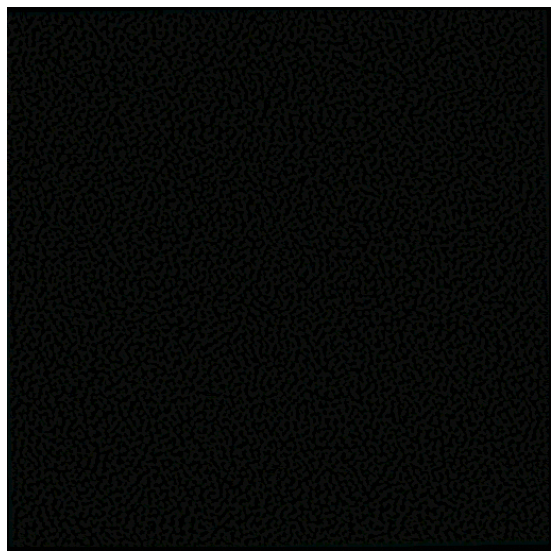

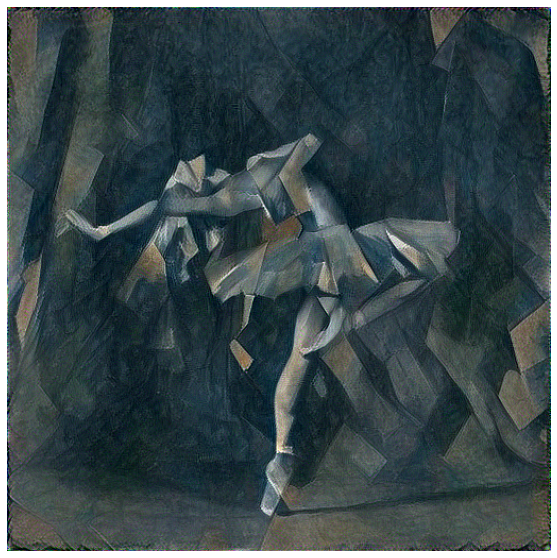

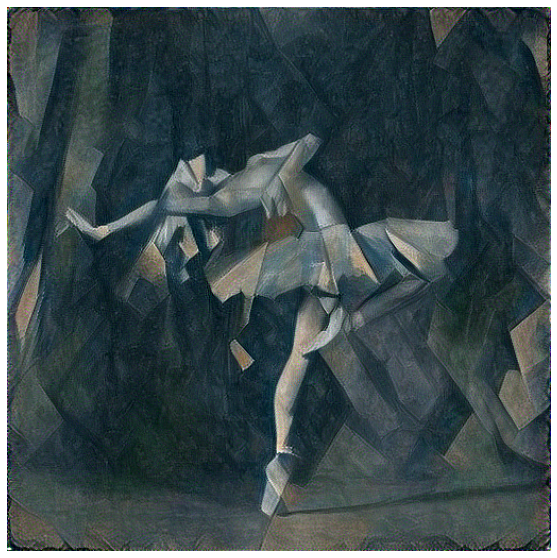

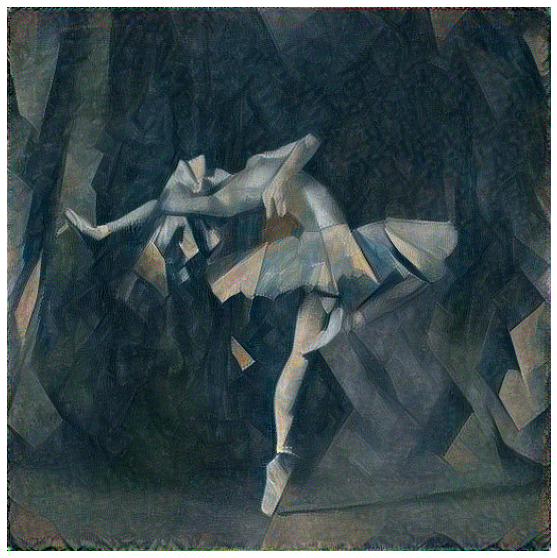

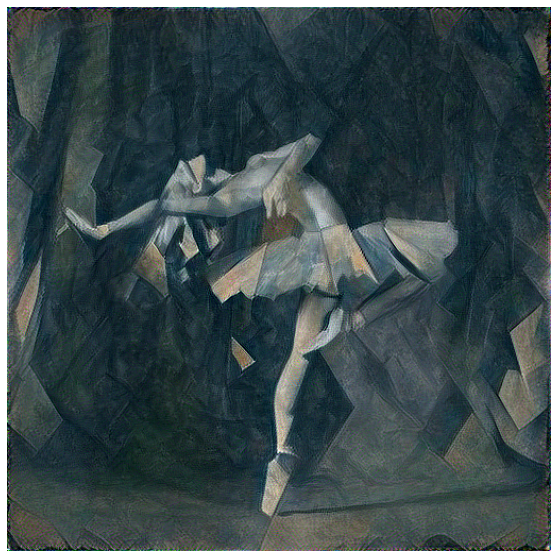

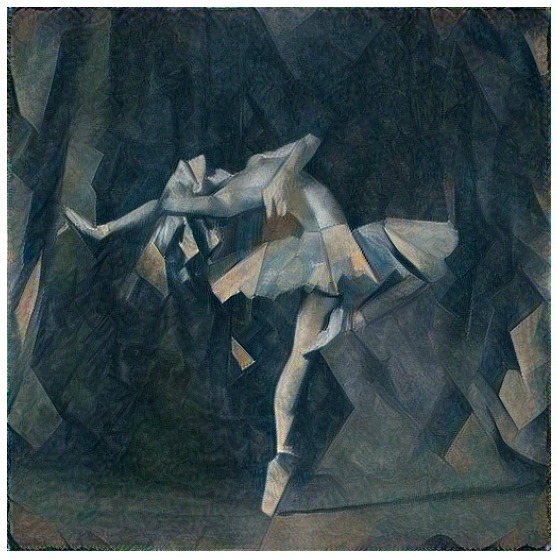

In [11]:
# NOTE(eugenhotaj): It's unclear from Gatys et al. whether to use the outputs of
# the conv layer or the (ReLU) activations. We use the latter here as ad-hoc
# experiments did not show a difference in quality, although the loss seems to
# be a lot higher when using the conv layer outputs.
vgg_default_content_layers = ['relu4_2']
vgg_default_style_layers = [
  'relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

# Uncomment one of the lines below to use as the input_img to optimize.
input_img = None
# input_img = content_img.clone()
# input_img = style_img.clone()

output = run_style_transfer(
    model=model, 
    content_img=content_img, 
    style_img=style_img,
    # Note(eugenhotaj): Gatys et al. use conv4_2 as the content layer. However,
    # we found that relu2_2 produces more visually appealing results.
    content_layers=['relu2_2'],
    style_layers=vgg_default_style_layers,
    num_steps=1024,
    content_weight=1,
    style_weight=500,
    log_steps=250)

# Compositional Pattern Producing Networks (TODO: move into separate nb)

## Random Network Hallucination

In [0]:
def init_weights(layer):
  """Initializes layer weights and biases.
  
  The weights are randomly sampled from a unit normal distribution. This is 
  extremley important to produce pleasing images. Using Xavier or Kaiming 
  initialization leads to gray images being produces as the model output tends
  closer to .5 with deeper and deeper networks. 

  The bias initialization is largely irrelevant. We initialize to 1. here.

  Args:
    layer: The layer to initialize.
  """
  if type(layer) == nn.Linear:
    init.normal_(layer.weight)
    init.constant_(layer.bias, 1.)

def random_fcnn(n_layers, n_units, activation=nn.Tanh):
  """Creates a randomly initialized Fully Connected Neural Network.
  
  Args:
    n_layers: The number of hidden layers in the network.
    n_units: The number of units in each hidden layer.
    activation: The activation to use after each fully connected layer.
  Returns:
    The Fully Connectd Neural Network.
  """
  n_inputs, n_outputs = 2, 3  # (x, y) -> (r, g, b)
  model = nn.Sequential(
      nn.Linear(in_features=n_inputs, out_features=n_units),
      activation())
  for i in range(n_layers):
    model.add_module(
        name=f'fc_{i}', 
        module=nn.Linear(in_features=n_units, out_features=n_units))
    model.add_module(name=f'activation_{i}', module=activation())
  model.add_module(
      name='logits',
      module=nn.Linear(in_features=n_units, out_features=n_outputs))
  model.add_module(name='output', module=nn.Sigmoid())
  return model

def scale(x):
  """Scales the input to be in [0, 1].

  This is extremley important to produce peasing images, otherwise all you'll
  see are straight lines.

  Args:
    x: The matrix to scale to [0, 1] column wise.
  """ 
  min_size, max_size = np.min(x, axis=0), np.max(x, axis=0)
  return (x - min_size) / (max_size - min_size)

def generate_input_image(imsize=(100, 100)):
  """Generates scaled (x, y) coordinates for images of size imsize."""
  width, height = imsize
  meshgrid = np.meshgrid(range(width), range(height))
  coordinates = np.dstack(meshgrid).reshape((-1, 2)).astype(np.float32)
  # Swap to get coordinates in (x, y) instead of the (y, x) output from dstack.
  coordinates = coordinates[:, [1, 0]]
  coordinates = scale(coordinates)
  return coordinates

def reshape_output_image(image, imsize=(100, 100), grayscale=False):
  """Reshapes the given image to (imsize, imsize, 3)."""
  width, height = imsize
  image = image.reshape((width, height, 3))
  if grayscale:
    image = np.dot(image, [0.2989, 0.5870, 0.1140])
  return image

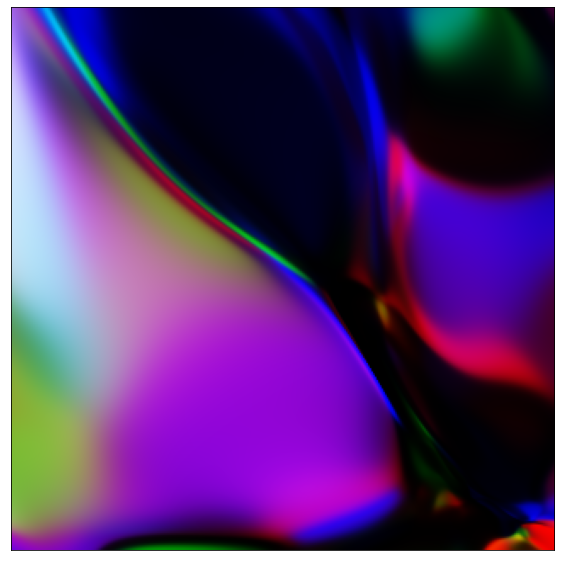

In [0]:
imsize = (320, 320)
n_layers = 6
n_units = 32

# Create and initialize the model.
model = random_fcnn(n_layers, n_units)
model.apply(init_weights)

# Generate the image.
image = generate_input_image(imsize=imsize)
image = model(torch.tensor(image)).data.numpy()

# Plot the image.
image = reshape_output_image(image, imsize=imsize, grayscale=False)
plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(image)

## Image Regression

[100]: loss=649.3141207885742
[200]: loss=420.30968353271487
[300]: loss=374.88008575439454
[400]: loss=253.27989898681642
[500]: loss=159.96354217529296
[600]: loss=81.9999607849121
[700]: loss=68.88172241210937
[800]: loss=64.73981967926025
[900]: loss=61.45765571594238
[1000]: loss=58.26441917419434
[1100]: loss=54.68611011505127
[1200]: loss=50.206027297973634
[1300]: loss=45.03571838378906
[1400]: loss=41.43043563842773
[1500]: loss=36.33275871276855
[1600]: loss=33.648435039520265
[1700]: loss=31.52573143005371
[1800]: loss=29.61966802597046
[1900]: loss=28.571652240753174
[2000]: loss=27.015799770355226
[2100]: loss=26.123053550720215
[2200]: loss=25.137061252593995
[2300]: loss=24.28873025894165
[2400]: loss=23.375569190979004
[2500]: loss=22.46490560531616
[2600]: loss=22.10568416595459
[2700]: loss=20.773155555725097
[2800]: loss=20.331410121917724
[2900]: loss=19.261857128143312
[3000]: loss=18.77522701263428
[3100]: loss=18.49533931732178
[3200]: loss=17.83794836997986
[330

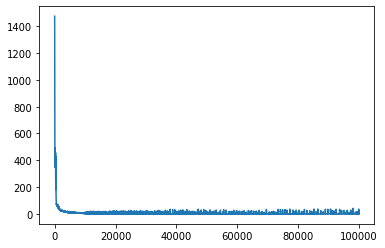

In [0]:
input_img = content_img.clone().to(get_device())
imsize = tuple(input_img.shape[2:])
n_layers = 12
n_units = 64

model = random_fcnn(n_layers, n_units, activation=nn.Tanh).to(get_device())
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.AdamW(model.parameters())

coordinates = generate_input_image(imsize)
coordinates = torch.tensor(
    coordinates, requires_grad=False, device=get_device())
losses = []
running_loss = 0
for i in range(100000):
  optimizer.zero_grad()
  preds = model(coordinates)
  preds = preds.reshape((1, *imsize, -1)).permute([0, 3, 1, 2])
  loss = criterion(preds, input_img)
  running_loss += loss.item()
  losses.append(loss.item())
  loss.backward()
  optimizer.step()

  if (i+1) % 100 == 0:
    print(f'{[i+1]}: loss={running_loss/100}')
    running_loss = 0
plt.plot(range(len(losses)), losses)

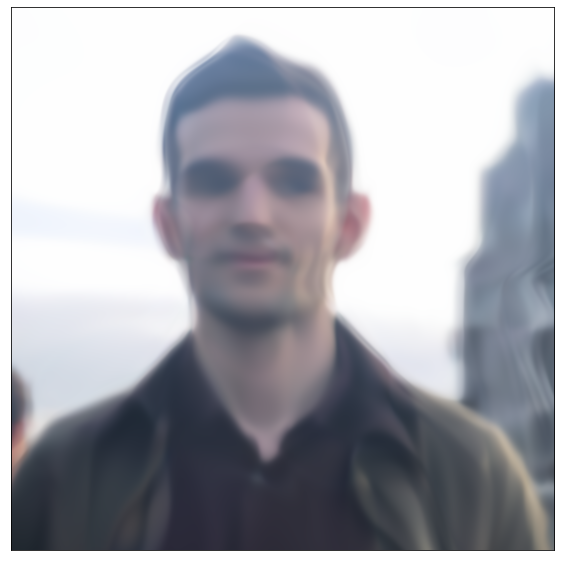

In [0]:
output_imsize = (1024, 1024)
coordinates = generate_input_image(imsize=output_imsize)
coordinates = torch.tensor(coordinates, requires_grad=False)
image = model.to('cpu')(coordinates).data.cpu().numpy()
image = reshape_output_image(image, imsize=output_imsize)
plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(image)